In [1]:
import numpy as np 
import sys 
import os 


import matplotlib.pyplot as plt
import shap

from chord import Chord
# load 
import sys
import time

from sklearn.model_selection import cross_val_score,train_test_split
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess
import os 
from scipy.stats import ranksums

from scipy import stats


if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)

Current system is Ubuntu


In [8]:
# Mixing HbO and HbR 

data_fold = 'allData/prognosis_mix_hb/pretreatment_response'
data = np.load(data_fold + '/hb_data.npy')
label = np.load(data_fold + '/label.npy')

In [9]:
def get_nine_region_data(data):
    def get_channel_index_of_region(ch_name):
        return np.array([int(ch_name[1:])-1 for ch_name in ch_name])

    # Posterior superior frontal cortex
    # PSFC_ch = ['C9', 'C10', 'C20', 'C21', 'C1', 'C2', 'C11', 'C12'] # 
    left_PSFC_location = ['C9', 'C10', 'C20', 'C21']
    right_PSFC_location = ['C1', 'C2', 'C11', 'C12']

    # Dorsolateral prefrontal cortex
    # DPC_ch = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29', 'C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']
    left_DPC_location = ['C7','C8', 'C17', 'C18', 'C19', 'C28', 'C29']
    right_DPC_location = ['C3', 'C4', 'C13', 'C14', 'C15', 'C24', 'C25']

    #Superior temporal gyrus
    # STG_ch = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44', 'C30', 'C31', 'C41', 'C42', 'C51', 'Cnum_of_region'] #
    left_STG_location = ['C22', 'C23', 'C32', 'C33', 'C43', 'C44']
    right_STG_location = ['C30', 'C31', 'C41', 'C42', 'C51', 'C52']

    # Ventrolateral prefrontal cortex
    # VPC_ch = ['C34', 'C35', 'C45', 'C46','C39', 'C40', 'C49', 'C50'] # 
    left_VPC_location = ['C34', 'C35', 'C45', 'C46']
    right_VPC_location = ['C39', 'C40', 'C49', 'C50']

    # Medial prefrontal cortex
    MPC_location = ['C5', 'C6', 'C16', 'C26', 'C27', 'C36', 'C37', 'C38', 'C47', 'C48']  

    all_region_location = [left_PSFC_location, right_PSFC_location, left_DPC_location, right_DPC_location, left_STG_location, right_STG_location, left_VPC_location, right_VPC_location, MPC_location]
    all_region_location = [get_channel_index_of_region(i) for i in all_region_location]
    print(len(all_region_location))
    print(all_region_location)


    nine_region_data = np.zeros((data.shape[0], len(all_region_location), data.shape[2]))

    for i, region_ch in enumerate(all_region_location):
        region_data = data[:,region_ch,:]
        region_data = np.mean(region_data, axis=1)
        nine_region_data[:,i,:] = region_data
    return nine_region_data
nine_region_name = ['L-PSFC', 'R-PSFC', 'L-DPC', 'R-DPC', 'L-STG', 'R-STG', 'L-VPC', 'R-VPC', 'MPC']

nine_region_data = get_nine_region_data(data)

9
[array([ 8,  9, 19, 20]), array([ 0,  1, 10, 11]), array([ 6,  7, 16, 17, 18, 27, 28]), array([ 2,  3, 12, 13, 14, 23, 24]), array([21, 22, 31, 32, 42, 43]), array([29, 30, 40, 41, 50, 51]), array([33, 34, 44, 45]), array([38, 39, 48, 49]), array([ 4,  5, 15, 25, 26, 35, 36, 37, 46, 47])]


In [10]:
def fdr_fix_p(data):
    shape = data.shape
    num_of_region = shape[0]

    for view in range(shape[-1]):
        uncorrected_p = []
        for i in range(num_of_region):
            for j in range(num_of_region):
                if j<=i:
                    continue
                uncorrected_p.append(data[i,j, view])
        print(f" view: {view}, uncorrected_p: {uncorrected_p}")
        corrected_p = multipletests(uncorrected_p, alpha=0.05, method='fdr_bh')[1]
        print('length of corrected_p:', len(corrected_p))
        count = 0
        for i in range(num_of_region):
            for j in range(num_of_region):
                if j<=i:
                    continue
                else:
                    data[i, j, view] = corrected_p[count]
                    data[j, i, view] = corrected_p[count]
                    count += 1
    return data
    
def show(adj, labels, name, stats_method='mannwhitneyu', regions_name=None):
    # stats_method = 'ranksums' # 'ranksums' or 'mannwhitneyu'
    def zero_diagnonal(arr):
        # Loop over the first and last dimension
        for i in range(arr.shape[0]):  # Loop over subjects
            for j in range(arr.shape[-1]):  # Loop over views
                np.fill_diagonal(arr[i, :, :, j], 0)
        return arr
    num_of_region = adj.shape[1]
    adj = zero_diagnonal(adj)
    hc_adj = adj[np.where(labels==1)]
    md_adj = adj[np.where(labels==0)]
    count = 0

    num_view = adj.shape[-1]
    p_view = np.zeros((num_of_region,num_of_region,num_view))
    effect_size = np.zeros((num_of_region,num_of_region,num_view))
    stats = np.zeros((num_of_region,num_of_region,num_view))
    for view in range(num_view):
        for seed in range(num_of_region):
            for target in range(num_of_region):
                hc_val = hc_adj[:, seed, target, view]
                md_val = md_adj[:, seed, target, view]
                if stats_method == 'mannwhitneyu':
                    stat, p1 = mannwhitneyu(hc_val,md_val)
                elif stats_method == 'ranksums':
                    stat, p1 = ranksums(hc_val,md_val)
                else:
                    raise ValueError('stats_method should be mannwhitneyu or ranksums')
                p_view[seed, target, view] = p1
                stats[seed, target, view] = stat
                
                # Calculate Hedges' g
                effect_size[seed, target, view] = pg.compute_effsize(hc_val,md_val, eftype='Hedges')
    p_view = fdr_fix_p(p_view)
    # plt.figure()
    # plt.subplot(1, 3, 1)
    # plt.imshow(stats[:,:,0])
    # plt.colorbar()
    # plt.subplot(1, 3, 2)
    # plt.imshow(stats[:,:,1])
    # plt.colorbar()

    # plt.subplot(1,3,3)
    # plt.imshow(stats[:,:,2])
    # plt.colorbar()

    # plt.show()
    
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import LogNorm


    colors = ['red','white']
    # cmap = LinearSegmentedColormap.from_list('RedToWhite', colors)
    # colors = [(1, 0, 0), (1, 1, 1)]  # Red to White
    # colors = ['#FF0000', '#FF3333', '#FF6666', '#FF9999', '#FFCCCC', '#FFFFFF']
    # Create a colormap with the defined colors
    cmap = LinearSegmentedColormap.from_list('RedToWhite', colors, N=256)


    colors_effect_size = ['blue','white','red']
    # cmap = LinearSegmentedColormap.from_list('RedToWhite', colors)
    # colors = [(1, 0, 0), (1, 1, 1)]  # Red to White
    # colors = ['#FF0000', '#FF3333', '#FF6666', '#FF9999', '#FFCCCC', '#FFFFFF']
    # Create a colormap with the defined colors
    # Define the colors in hexadecimal format
    colors = ['#448196', 'white', '#c45c3d']

    # Create the custom color map
    cmap_effect_size = LinearSegmentedColormap.from_list('CustomColorMap', colors, N=256)

    # cmap_effect_size = LinearSegmentedColormap.from_list('BlueToWhiteToRed', colors_effect_size, N=256)

    # Set up a 2x4 grid for plotting
    fig, axes = plt.subplots(nrows=2, ncols=num_view, figsize=(12, 6))

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    A_adj_name = ['HbO', 'HbR', 'HbT']
    p_es = [' (P-value)', ' (Effect Size)']
    p_es_name = [[j + i for j in A_adj_name] for i in p_es]
    

    # Loop through images and axes to display each image
    for idx, ax in enumerate(axes):
        if idx < num_view: 
            im=ax.imshow(p_view[:,:,idx], norm=LogNorm(vmin=0.001, vmax=0.05), cmap=cmap)
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.05, ticks=[0.001, 0.01, 0.05])
            cbar.ax.set_yticklabels(['0.001', '0.01', '0.05'], fontsize=12, fontweight='bold')

            # ax.colorbar()
        else: 
            im=ax.imshow(effect_size[:,:,idx-num_view], vmin=-1.00, vmax=1.00, cmap=cmap_effect_size)
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.05, ticks=[-1.00, -0.5, 0, 0.5, 1.00])
            cbar.ax.set_yticklabels(['-1.00', '-0.5', '0', '0.5', '1.00'], fontsize=12, fontweight='bold')

            # ax.colorbar()
        # ax.axis('off')  # Turn off axis
        ax.set_title(f'{p_es_name[idx//num_view][idx%num_view]}',fontsize=13, fontweight='bold')  # Set title for each subplot
            # Set axis ticks
        
        if regions_name is None:
            regions_name = np.arange(num_of_region)
            
        ax.set_xticks(np.arange(num_of_region))
        ax.set_yticks(np.arange(num_of_region))

        # Set axis tick labels
        ax.set_xticklabels(regions_name, fontsize=12, fontweight='bold', rotation=45)
        ax.set_yticklabels(regions_name, fontsize=12, fontweight='bold')
        
        # ax.set_xlabel('Channels', fontsize=12, fontweight='bold')
        # ax.set_ylabel('Channels', fontsize=12, fontweight='bold')
        # fig.colorbar(im, ax=ax)  # Add colorbar for each subplot

        plt.tight_layout()
        
        # Remove spines for effect size
        if idx>=num_view:
            for spine in ax.spines.values():
                spine.set_visible(False)
        else:
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)  # 设置边框的厚度为0.5

    # plt.savefig('/figures/connectivity.png')
    # plt.savefig(output_fold+f'/stats_{stats_method}_responders_nonresponders_{name}.png')

    plt.show()            

In [11]:
nine_region_FC = np.zeros((nine_region_data.shape[0], nine_region_data.shape[1], nine_region_data.shape[1], 3))


def compute_correlation(x, y, method='pearsonr'):
    if method == 'pearsonr':
        corr, _ = stats.pearsonr(x, y)
    else:
        # raise
        raise ValueError('Method not supported')
    return corr

def compute_dmfc(data, num_of_region=9):
    dm_data = data
    feature_shape = dm_data.shape
    if feature_shape[1] != num_of_region:
        raise ValueError(
            'The shape of feature_shape should be (subject, num_of_region, time)')
    else:
        print(
            "Nice, the feature_shape is correct, its shape[1] is num_of_region (channel)")

    dmfc = np.zeros((dm_data.shape[0], dm_data.shape[1], dm_data.shape[1]))
    for sub in range(feature_shape[0]):
        for ch_1 in range(feature_shape[1]):
            for ch_2 in range(feature_shape[1]):
                if ch_2 <= ch_1:
                    continue
                corr = compute_correlation(
                    dm_data[sub, ch_1], dm_data[sub, ch_2])
                dmfc[sub, ch_1, ch_2] = corr
                dmfc[sub, ch_2, ch_1] = corr
    return dmfc


def seperate_hb_compute_its_dmfc(hb):
    shape = hb.shape
    hbo = hb[..., 0::2]
    hbr = hb[..., 1::2]
    hbt = hbo+hbr
    fc_hbo = compute_dmfc(hbo)
    fc_hbr = compute_dmfc(hbr)
    fc_hbt = compute_dmfc(hbt)
    fc_hb = np.concatenate(
        (fc_hbo[..., np.newaxis], fc_hbr[..., np.newaxis], fc_hbt[..., np.newaxis]), axis=-1)

    return fc_hb

nine_region_FC = seperate_hb_compute_its_dmfc(nine_region_data)

Nice, the feature_shape is correct, its shape[1] is num_of_region (channel)
Nice, the feature_shape is correct, its shape[1] is num_of_region (channel)
Nice, the feature_shape is correct, its shape[1] is num_of_region (channel)


 view: 0, uncorrected_p: [0.715471778652599, 0.9620782833741496, 0.987355194423508, 0.6572159973411411, 0.9494525195827553, 0.8991077059135244, 0.8491657912620233, 0.26048354740937885, 0.02441735419230902, 0.1937438206565193, 0.1537610108349084, 0.8616027072229339, 0.10944198945513996, 0.11299866834966883, 0.2283995284318302, 0.6120464418511691, 0.9116638948284465, 0.9116638948284465, 0.6802932451794763, 0.8865767217855367, 0.9368394343815467, 0.5365130447184707, 0.8244072390754491, 0.11664581246914686, 0.32579854632775873, 0.21638831530070723, 0.40092263775141734, 0.29555822329935144, 0.7512651968617754, 0.7998221876154478, 0.9242421795157034, 0.4374064429023594, 0.3747988343539521, 0.6572159973411411, 0.4098679649951317, 0.7512651968617754]
length of corrected_p: 36
 view: 1, uncorrected_p: [0.6802932451794763, 0.03113003998529647, 0.40092263775141734, 0.7998221876154478, 0.6344610534960005, 0.9747135644710185, 0.9368394343815467, 0.020673633499603963, 0.06369860957346998, 0.63446105

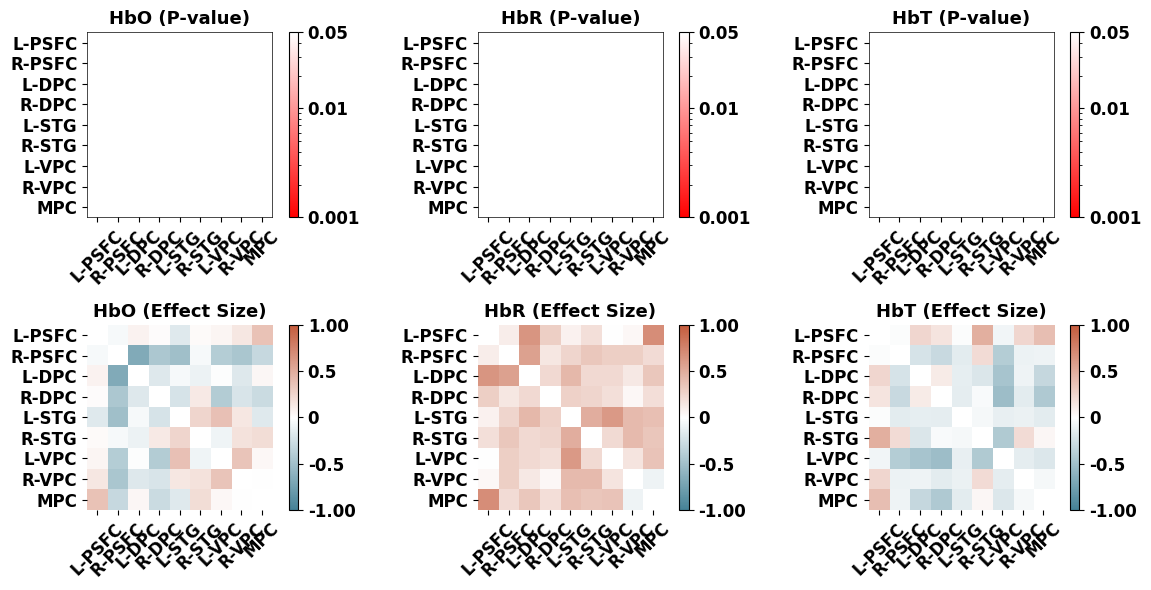

: 

In [12]:
show(nine_region_FC, label, 'nine_region', stats_method='mannwhitneyu', regions_name=nine_region_name)